/tmp/ipykernel_8981/2773308706.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', N // stack_size).colors


[('aeroplane',
  0.711129305132126,
  0.8593735577458465,
  0.8687155864253068,
  0.009342028679460324),
 ('bicycle',
  0.20571927808869322,
  0.3859288034712283,
  0.42081389179272555,
  0.034885088321497226),
 ('bird',
  0.8816985323793451,
  0.9031586140354237,
  0.9017567699075144,
  -0.0014018441279093352),
 ('boat',
  0.6848071609413553,
  0.8261323710948628,
  0.8402434030706812,
  0.014111031975818422),
 ('bottle',
  0.47136071211491404,
  0.8916802912176491,
  0.9360064567662917,
  0.04432616554864255),
 ('bus',
  0.8416040844852483,
  0.9177610378450302,
  0.9418569316711676,
  0.024095893826137416),
 ('car',
  0.7259520399312815,
  0.8939480226541988,
  0.9268321605260311,
  0.03288413787183231),
 ('cat',
  0.8310930160104335,
  0.8861959773491599,
  0.8841778689491263,
  -0.0020181084000335803),
 ('chair',
  0.443958712266989,
  0.7226236371816881,
  0.8314022186197567,
  0.10877858143806862),
 ('cow',
  0.6778051585124382,
  0.8330360029906495,
  0.8483077070020075,
  0.01

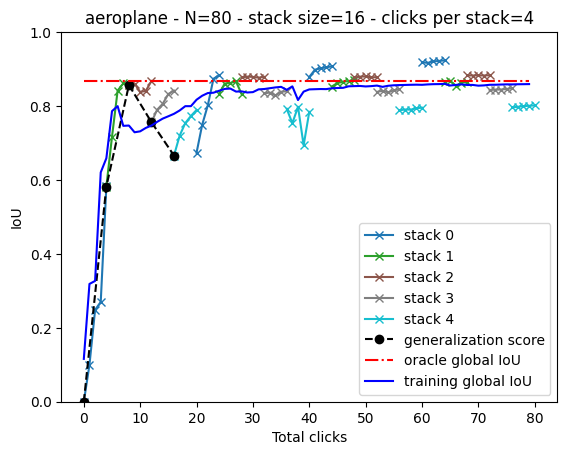

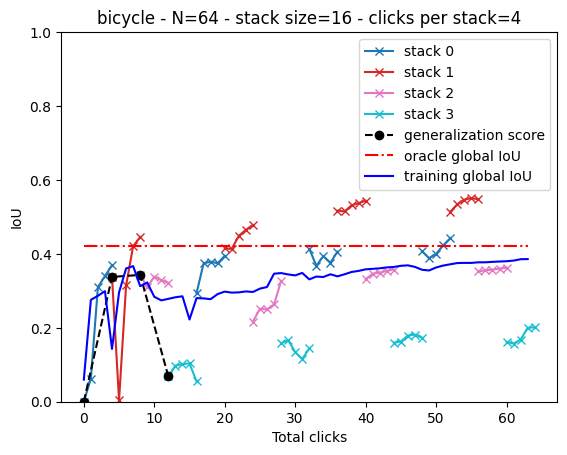

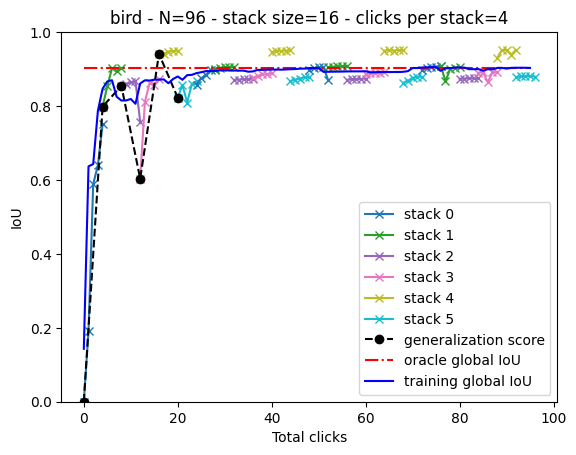

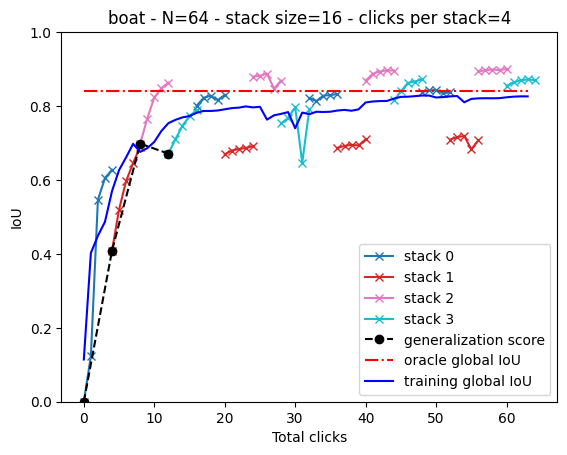

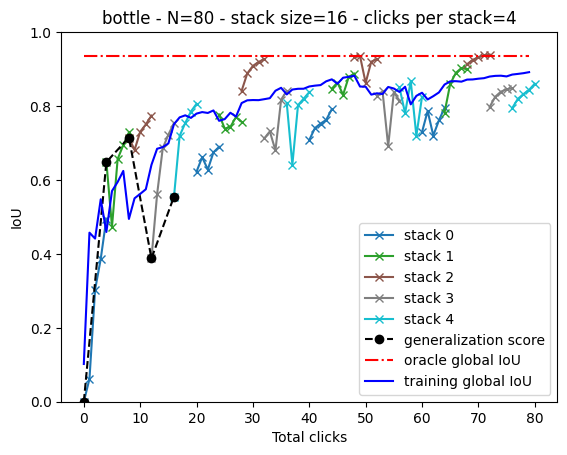

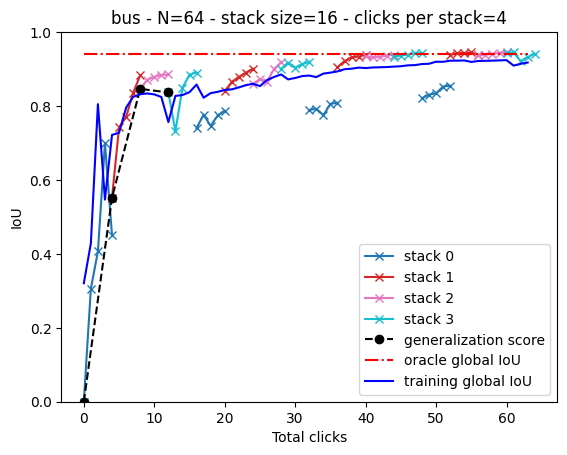

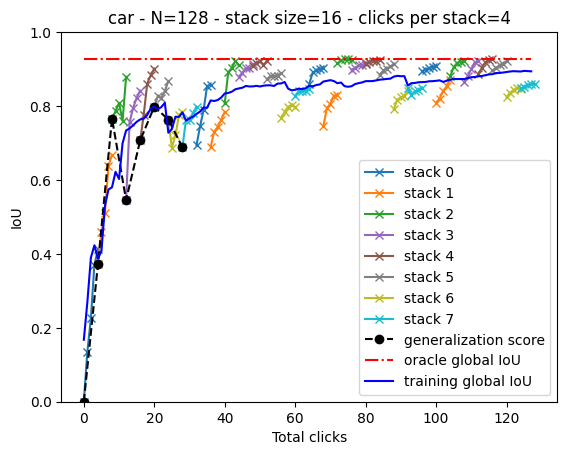

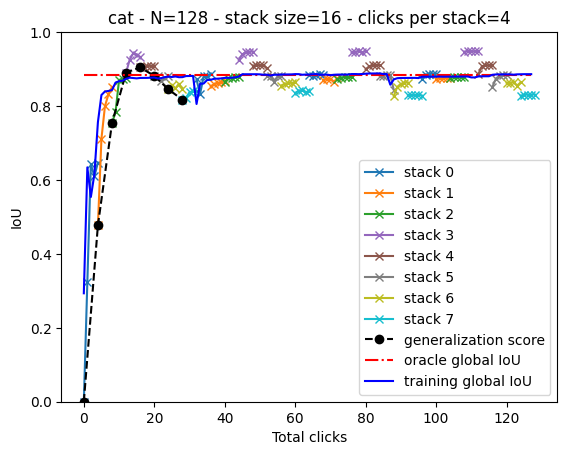

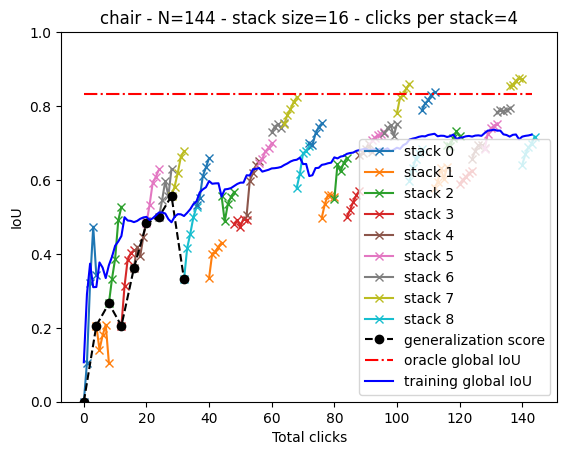

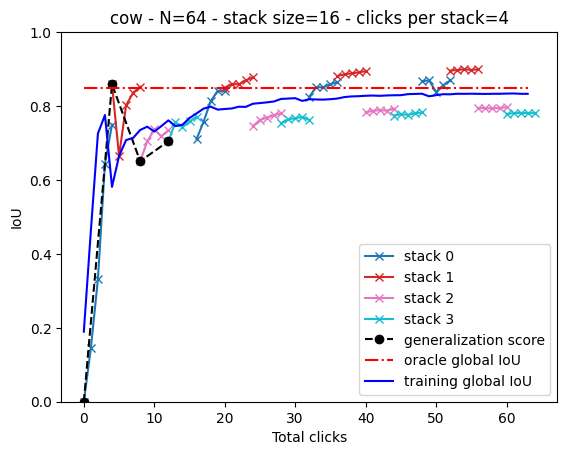

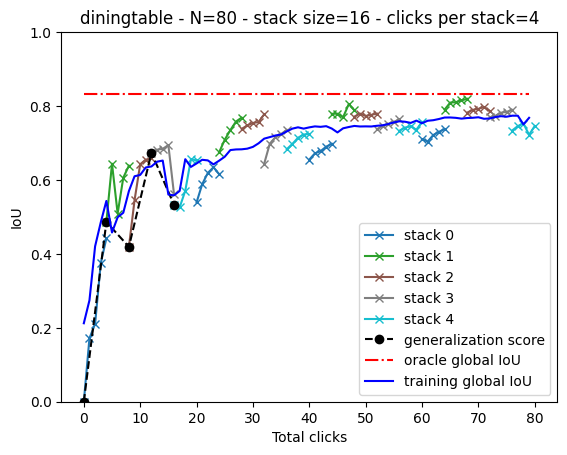

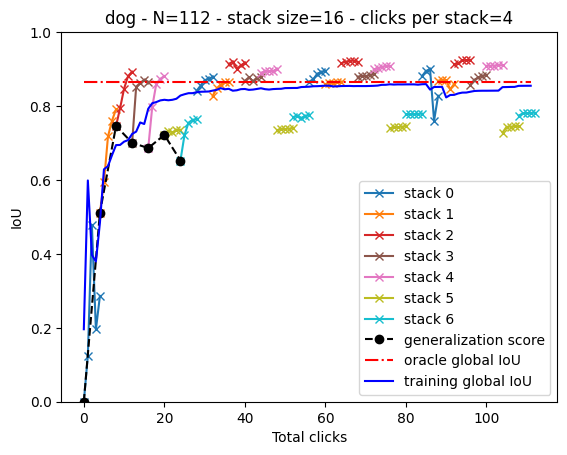

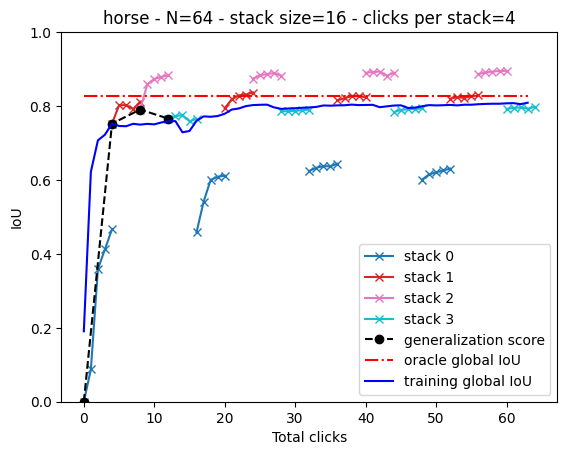

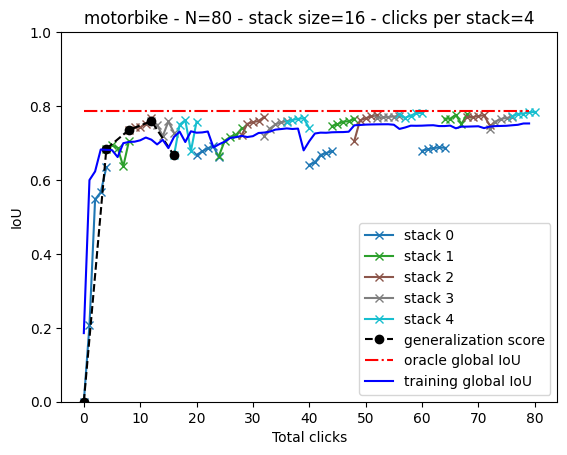

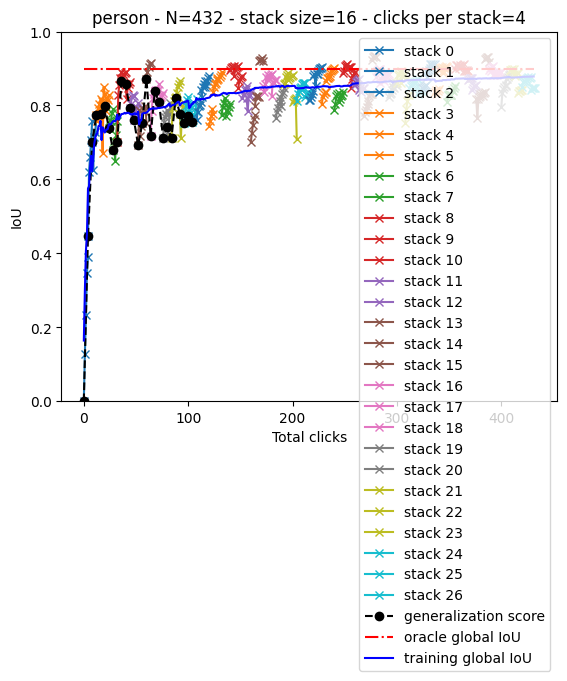

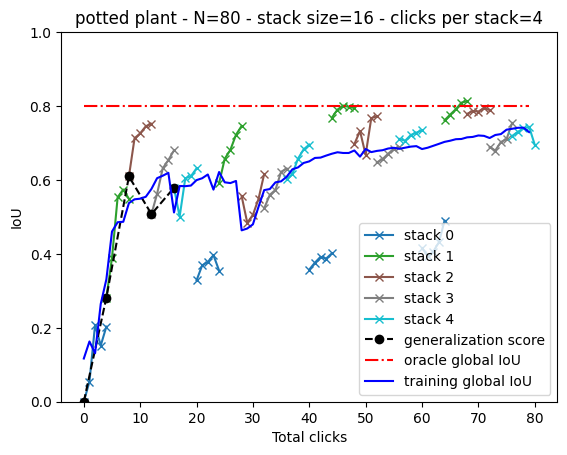

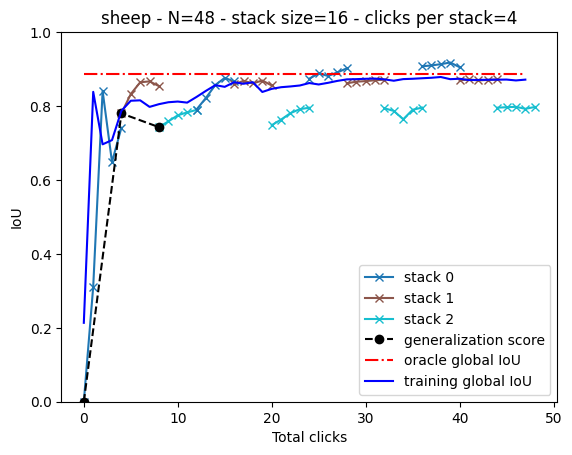

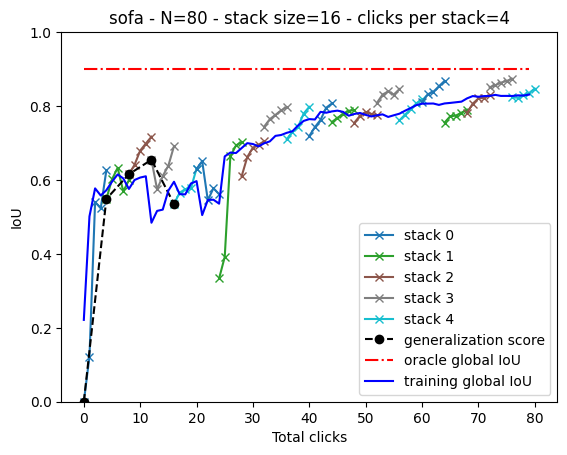

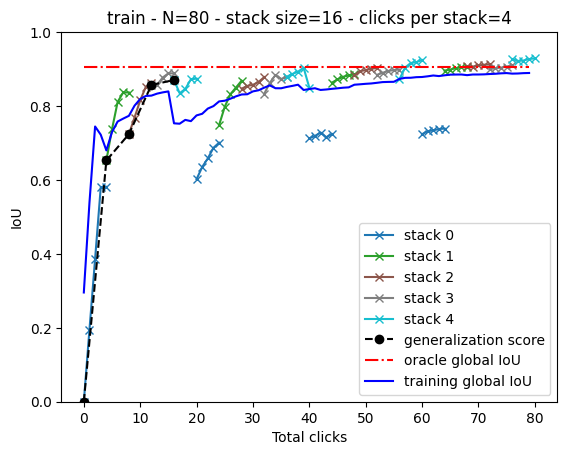

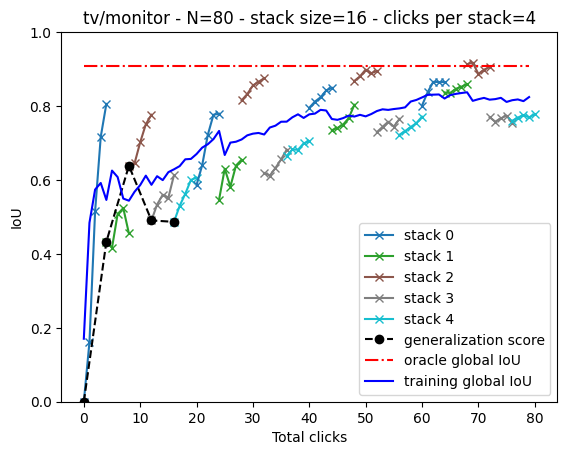

In [2]:
import os
import numpy as np
import ast
import json
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append('..')
from dataloaders.pascalvoc import classes
from metrics import aggregate_metrics
from pprint import pprint


mIoU = []
oracles = []
final_training_perf = []
overall_mean = []
for ind in range(1, 21):
    pascal_class = list(classes.keys())[ind]
    N = list(Path('../runs').glob(f'{pascal_class}_iiss_N*'))[0].name.split('_')[2][1:]
    N = int(N)
    stack_size = 16
    clicks_per_stack = 4

    run_path = Path(f'../runs/{pascal_class}_iiss_N{N}_tc{N}_s{stack_size}_cs{clicks_per_stack}/')
    metrics_path = run_path / 'metrics'
    oracle_res_path = f'../runs/{pascal_class}_oracle_N{N}'
    training_res_path = run_path / 'metrics_vs_t.json'

    metric_name = 'jacc'

    plt.figure()
    # get eight colors distinct from each other and the white background
    colors = plt.cm.get_cmap('tab10', N // stack_size).colors


    generalization_curve = []
    init_x = 0
    for metric in sorted(os.listdir(metrics_path)):
        sweep = int(metric.split('_')[1])
        stack = int(metric.split('_')[3])
        met_list_dict = json.load(open(os.path.join(metrics_path, metric)))
        ious = [d[metric_name] for d in met_list_dict]

        if sweep == 0:
            plt.plot(range(init_x, init_x+len(ious)), ious, '-x', label=f'stack {stack}', c=colors[stack])
            generalization_curve.append((init_x, ious[0]))
        else:  # the same but without legend
            plt.plot(range(init_x, init_x + len(ious)), ious, '-x', c=colors[stack])
        init_x += len(ious) - 1
    mIoU += [np.mean([generalization_curve[-1][1], generalization_curve[-2][1]])]


    plt.plot([p[0] for p in generalization_curve], [p[1] for p in generalization_curve], '--o', label='generalization score', c='black')


    oracle_res = json.load(open(os.path.join(oracle_res_path, 'metrics.json')))
    oracles.append(oracle_res[metric_name])
    plt.plot(range(N), [oracle_res[metric_name]]*N, '-.', label='oracle global IoU', c=(1, 0, 0))
    # plt.plot(range(64), [oracle_res['avg_'+metric_name]]*64, '-.', label='oracle avg IoU', c=(0.5, 0, 0))

    # read training res with ast
    with open(training_res_path, 'r') as f:
        training_res = ast.literal_eval(f.read())
    overall_mean += training_res.copy()
    training_metrics = [aggregate_metrics(training_res[i]) for i in range(len(training_res))]
    final_training_perf.append(training_metrics[-1][metric_name])
    plt.plot([m[metric_name] for m in training_metrics],  label='training global IoU', c=(0, 0, 1))

    plt.title(f'{pascal_class} - N={N} - stack size={stack_size} - clicks per stack={clicks_per_stack}')
    plt.ylabel('IoU')
    plt.xlabel('Total clicks')
    plt.ylim(0, 1)
    plt.legend()

ftp, miou, oracles = np.array(final_training_perf), np.array(mIoU), np.array(oracles)
mdiff = oracles - ftp
pascal_classes = [list(classes.keys())[ind] for ind in range(1,21)]
overall_mean = aggregate_metrics([e for l1 in overall_mean for e in l1])
pprint(list(zip(pascal_classes, miou, ftp, oracles, mdiff)))

print('global')
pprint('mIoU: ' + str(np.mean(miou)))
pprint('overall mean:' + str(overall_mean[metric_name]))
pprint('ftp: ' + str(np.mean(ftp)))
pprint('oracle: ' + str(np.mean(oracles))) 
pprint('mdiff: ' + str(np.mean(mdiff)))